# Overview

# Business Understanding

# Problem Statement

# Data Understanding 

# Objectives

1. To build a time series forecasting model to predict Kenya’s inflation trends using historical economic indicators such as CPI, food CPI, interest   rates, exchange rates, and GDP metrics.

2. To examine the relationship between overall CPI and food CPI, understanding how food price changes impact overall inflation trends.

3. To analyze the temporal patterns of macroeconomic indicators such as interest rates, exchange rates, GDP growth, unemployment rate, and tax rates over the study period.

4. To assess correlations between inflation and other variables (e.g., GDP value, VAT rate, PAYE bracket), providing insight into key economic drivers of inflation.

5. To build and evaluate different forecasting models (ARIMA, SARIMA, LSTM, and XGBoost), comparing their performance accurately for predicting inflation in Kenya.

6. To evaluate the impact of external factors (e.g., global commodity prices, political events) on inflation in Kenya using qualitative and quantitative methods.

7. To visualize Kenya's inflation data and model forecasts through interactive dashboards for easier interpretation and decision-making.

# Success Metrics

In [1]:
#importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import db_config 
import warnings

from scipy.stats import pearsonr
from sqlalchemy import create_engine
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Creating database connection
engine = create_engine(db_config.DB_URL)

In [3]:
# Fetch data
query = "SELECT * FROM cpi;"
cpi = pd.read_sql(query, con=engine)
print(cpi.head())

# Close connection
engine.dispose()

   year     month  inflation rate (%)     cpi  food cpi  \
0  2025  February                 3.5  143.12     118.0   
1  2025   January                 3.3  142.68     116.1   
2  2024  December                 3.0  141.66     120.4   
3  2024  November                 2.8  140.81     120.7   
4  2024   October                 2.7  140.44     119.9   

   exchange rate\n (kes/usd)  interest rate (%)  
0                     128.70              10.75  
1                     129.00              11.25  
2                     128.85              11.25  
3                     129.50              12.00  
4                     128.50              12.00  


In [4]:
# Fetch data
query = "SELECT * FROM gdpgrowth;"
gdpgrowth = pd.read_sql(query, con=engine)
print(gdpgrowth.head())

# Close connection
engine.dispose()

   year quarter  gdp growth rate (%)  gdp value (kes billion)
0  2025      Q1                  NaN                      NaN
1  2025      Q2                  NaN                      NaN
2  2025      Q3                  NaN                      NaN
3  2025      Q4                  NaN                      NaN
4  2024      Q1                  5.3                  14000.0


In [5]:
# Fetch data
query = "SELECT * FROM taxrates;"
taxrates = pd.read_sql(query, con=engine)
print(taxrates.head())

# Close connection
engine.dispose()

   year quarter  vat rate (%) paye bracket (kes)  tax rate (%)
0  2025      Q1            16         0 – 24,000          10.0
1  2025      Q1            16    24,001 – 32,333          15.0
2  2025      Q1            16   32,334 – 500,000          25.0
3  2025      Q1            16  500,001 – 800,000          30.0
4  2025      Q1            16      Above 800,000          35.0


In [6]:
# Fetch data
query = "SELECT * FROM unemployment;"
unemployment = pd.read_sql(query, con=engine)
print(unemployment.head())

# Close connection
engine.dispose()

   year unemployment rate (%)
0  2025                  None
1  2024                  None
2  2023                 5.68%
3  2022                 5.81%
4  2021                 5.69%


The database has been successfully connected and the tables have been loaded.

**1.cpi**

In [7]:
# Summary statistics for numerical columns in cpi
cpi.describe()

,year,inflation rate (%),cpi,food cpi,exchange rate\n (kes/usd),interest rate (%)
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,2019.590164,6.160902,153.417828,108.523770,111.874918,9.389344
std,2.945101,1.709468,31.533722,16.077175,14.948723,1.777107
min,2015.000000,2.700000,107.174000,88.900000,91.300000,7.000000
25%,2017.000000,5.000000,125.867500,95.900000,101.725000,8.250000
50%,2020.000000,5.855000,148.275000,101.850000,104.325000,9.250000
75%,2022.000000,6.967500,183.462500,118.450000,119.775000,10.500000
max,2025.000000,11.700000,205.900000,156.800000,160.000000,13.000000


In [8]:
# Categorical and numerical variables
cat_vars = []
num_vars = []

for col in cpi.columns:
    if cpi[col].dtype == 'object':
        cat_vars.append(col)
    else:
        num_vars.append(col)
print("-------------------------------------------------------------------------------------------------------------------")
print('Categorical variables:', cat_vars)
print("-------------------------------------------------------------------------------------------------------------------")
print('Numerical variables:', num_vars)
print("-------------------------------------------------------------------------------------------------------------------")

-------------------------------------------------------------------------------------------------------------------
Categorical variables: ['month']
-------------------------------------------------------------------------------------------------------------------
Numerical variables: ['year', 'inflation rate (%)', 'cpi', 'food cpi', 'exchange rate\n (kes/usd)', 'interest rate (%)']
-------------------------------------------------------------------------------------------------------------------


In [9]:
# Data types and non-null counts in cpi dataset
cpi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      122 non-null    int64  
 1   month                     122 non-null    object 
 2   inflation rate (%)        122 non-null    float64
 3   cpi                       122 non-null    float64
 4   food cpi                  122 non-null    float64
 5   exchange rate
 (kes/usd)  122 non-null    float64
 6   interest rate (%)         122 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 6.8+ KB


**2.gdpgrowth**

In [10]:
# Summary statistics for numerical columns in gdpgrowth
gdpgrowth.describe()

,year,gdp growth rate (%),gdp value (kes billion)
count,44.000000,40.00000,40.000000
mean,2020.000000,4.78500,11483.750000
std,3.198837,2.12501,1624.152146
min,2015.000000,-5.70000,8600.000000
25%,2017.000000,4.87500,10212.500000
50%,2020.000000,5.30000,11400.000000
75%,2023.000000,5.70000,12937.500000
max,2025.000000,6.20000,14000.000000


In [11]:
# Categorical and numerical variables
cat_vars = []
num_vars = []

for col in gdpgrowth.columns:
    if gdpgrowth[col].dtype == 'object':
        cat_vars.append(col)
    else:
        num_vars.append(col)
print("-------------------------------------------------------------------------------------------------------------------")
print('Categorical variables:', cat_vars)
print("-------------------------------------------------------------------------------------------------------------------")
print('Numerical variables:', num_vars)
print("-------------------------------------------------------------------------------------------------------------------")

-------------------------------------------------------------------------------------------------------------------
Categorical variables: ['quarter']
-------------------------------------------------------------------------------------------------------------------
Numerical variables: ['year', 'gdp growth rate (%)', 'gdp value (kes billion)']
-------------------------------------------------------------------------------------------------------------------


In [12]:
# Data types and non-null counts in gdpgrowth dataset
gdpgrowth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     44 non-null     int64  
 1   quarter                  44 non-null     object 
 2   gdp growth rate (%)      40 non-null     float64
 3   gdp value (kes billion)  40 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.5+ KB


**3.taxrates**

In [13]:
# Summary statistics for numerical columns in taxrates
taxrates.describe()

,year,vat rate (%),tax rate (%)
count,220.000000,220.000000,220.000000
mean,2020.000000,15.863636,24.681818
std,3.169489,0.505265,9.315065
min,2015.000000,14.000000,10.000000
25%,2017.000000,16.000000,15.000000
50%,2020.000000,16.000000,30.000000
75%,2023.000000,16.000000,32.500000
max,2025.000000,16.000000,35.000000


In [14]:
# Categorical and numerical variables
cat_vars = []
num_vars = []

for col in taxrates.columns:
    if taxrates[col].dtype == 'object':
        cat_vars.append(col)
    else:
        num_vars.append(col)
print("-------------------------------------------------------------------------------------------------------------------")
print('Categorical variables:', cat_vars)
print("-------------------------------------------------------------------------------------------------------------------")
print('Numerical variables:', num_vars)
print("-------------------------------------------------------------------------------------------------------------------")

-------------------------------------------------------------------------------------------------------------------
Categorical variables: ['quarter', 'paye bracket (kes)']
-------------------------------------------------------------------------------------------------------------------
Numerical variables: ['year', 'vat rate (%)', 'tax rate (%)']
-------------------------------------------------------------------------------------------------------------------


In [15]:
# Data types and non-null counts in taxrates dataset
taxrates.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                220 non-null    int64  
 1   quarter             220 non-null    object 
 2   vat rate (%)        220 non-null    int64  
 3   paye bracket (kes)  220 non-null    object 
 4   tax rate (%)        220 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 8.7+ KB


**4.unemployment**

In [16]:
# Summary statistics for numerical columns in unemployment
unemployment.describe()

,year
count,11.000000
mean,2020.000000
std,3.316625
min,2015.000000
25%,2017.500000
50%,2020.000000
75%,2022.500000
max,2025.000000


In [17]:
# Categorical and numerical variables
cat_vars = []
num_vars = []

for col in unemployment.columns:
    if unemployment[col].dtype == 'object':
        cat_vars.append(col)
    else:
        num_vars.append(col)
print("-------------------------------------------------------------------------------------------------------------------")
print('Categorical variables:', cat_vars)
print("-------------------------------------------------------------------------------------------------------------------")
print('Numerical variables:', num_vars)
print("-------------------------------------------------------------------------------------------------------------------")

-------------------------------------------------------------------------------------------------------------------
Categorical variables: ['unemployment rate (%)']
-------------------------------------------------------------------------------------------------------------------
Numerical variables: ['year']
-------------------------------------------------------------------------------------------------------------------


In [18]:
# Data types and non-null counts in unemployment dataset
unemployment.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   year                   11 non-null     int64 
 1   unemployment rate (%)  9 non-null      object
dtypes: int64(1), object(1)
memory usage: 308.0+ bytes


## Checking for outliers

**1.cpi**

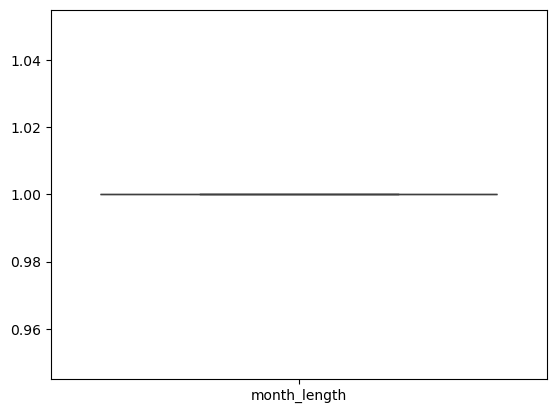

In [19]:
# categorical columns
# Compute word count for cpi
cpi['month_length'] = cpi['month'].apply(lambda x: len(x.split()))

# Boxplot of text lengths
sns.boxplot(data=cpi[['month_length']])
plt.show()

Data is concetrated at the middle with no outliers

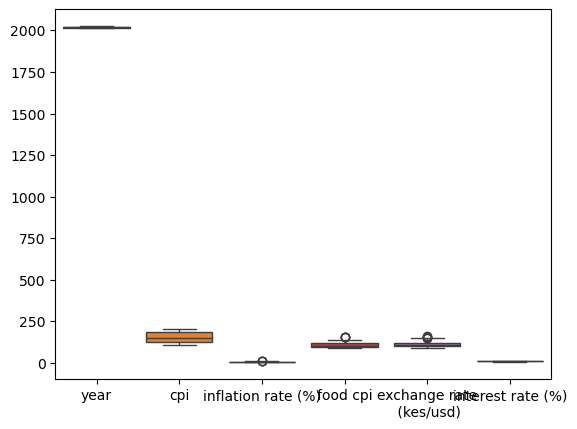

In [20]:
# Plot boxplots for numerical column to check for outliers for the cpi table
sns.boxplot(data=cpi[[ 'year', 'cpi', 'inflation rate (%)', 'food cpi', 'exchange rate\n (kes/usd)', 'interest rate (%)']])
plt.show()

Year : Data is concentrated at the top with no outliers

cpi : Wide data range with no outliers.

inflation rate (%) :

food cpi :

exchange rate\n (kes/usd) :

interest rate (%) :

**2.gdpgrowth**

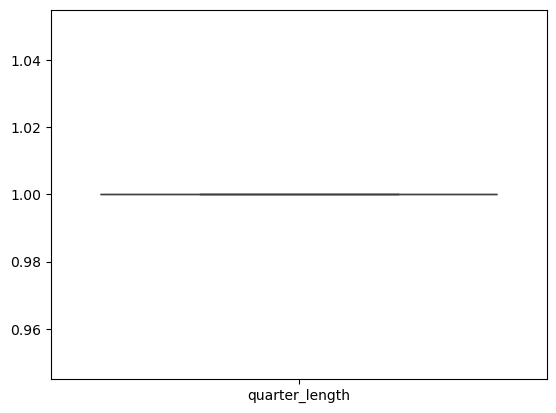

In [21]:
# categorical columns
# Compute word count for gdpgrowth
gdpgrowth['quarter_length'] = gdpgrowth['quarter'].apply(lambda x: len(x.split()))

# Boxplot of text lengths
sns.boxplot(data=gdpgrowth[['quarter_length']])
plt.show()

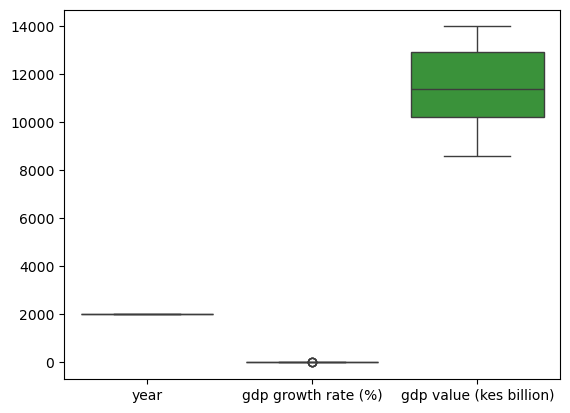

In [22]:
# Plot boxplots for numerical column to check for outliers for the gdpgrowth table
sns.boxplot(data=gdpgrowth[['year', 'gdp growth rate (%)', 'gdp value (kes billion)']])
plt.show()

**3.taxrates**

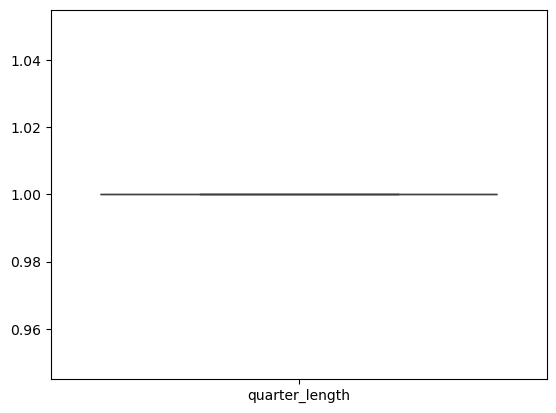

In [23]:
# categorical columns
# Compute word count for taxrates
taxrates['quarter_length'] = taxrates['quarter'].apply(lambda x: len(x.split()))
taxrates['paye_bracket_(kes)_length'] = taxrates['paye bracket (kes)'].apply(lambda x: len(x.split()))

# Boxplot of text lengths
sns.boxplot(data=taxrates[['quarter_length', 'paye bracket (kes)']])
plt.show()

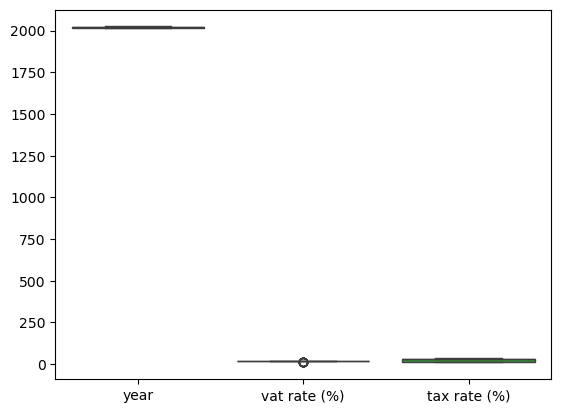

In [24]:
# Plot boxplots for numerical column to check for outliers for the taxrates table
sns.boxplot(data=taxrates[['year', 'vat rate (%)', 'tax rate (%)']])
plt.show()

**4.unemployment**

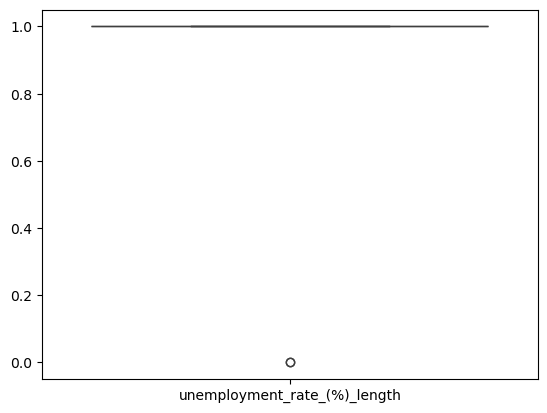

In [25]:
# categorical columns
# Handle NaN values by filling them with an empty string
unemployment['unemployment rate (%)'] = unemployment['unemployment rate (%)'].fillna("")

# Compute word count for unemployment
unemployment['unemployment_rate_(%)_length'] = unemployment['unemployment rate (%)'].apply(lambda x: len(x.split()))

# Boxplot of text lengths
sns.boxplot(data=unemployment[['unemployment_rate_(%)_length']])
plt.show()

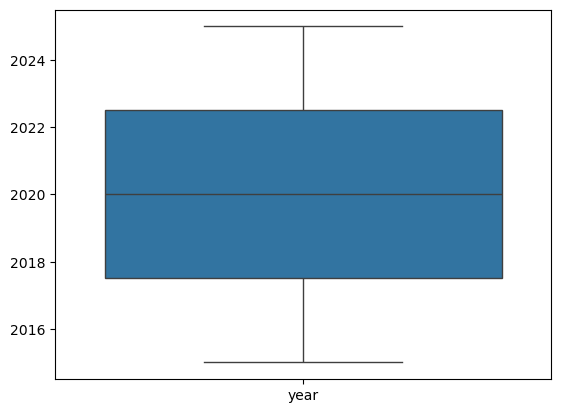

In [26]:
# Plot boxplots for numerical column to check for outliers for the unemployment table
sns.boxplot(data=unemployment[['year']])
plt.show()

# Exploratory Data Analysis(EDA)

We are going to conduct a comprehensive exploration of the data through univariate, bivariate, and multivariate analysis.

### 1. Univariate Analysis

Univariate analysis involves examining a single variable at a time to understand its distribution, central tendency, and variability.

I used it because I wanted to understand the distribution of inflation rates.

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1296\2145231596.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(inflation_values, shade=True, color='green')


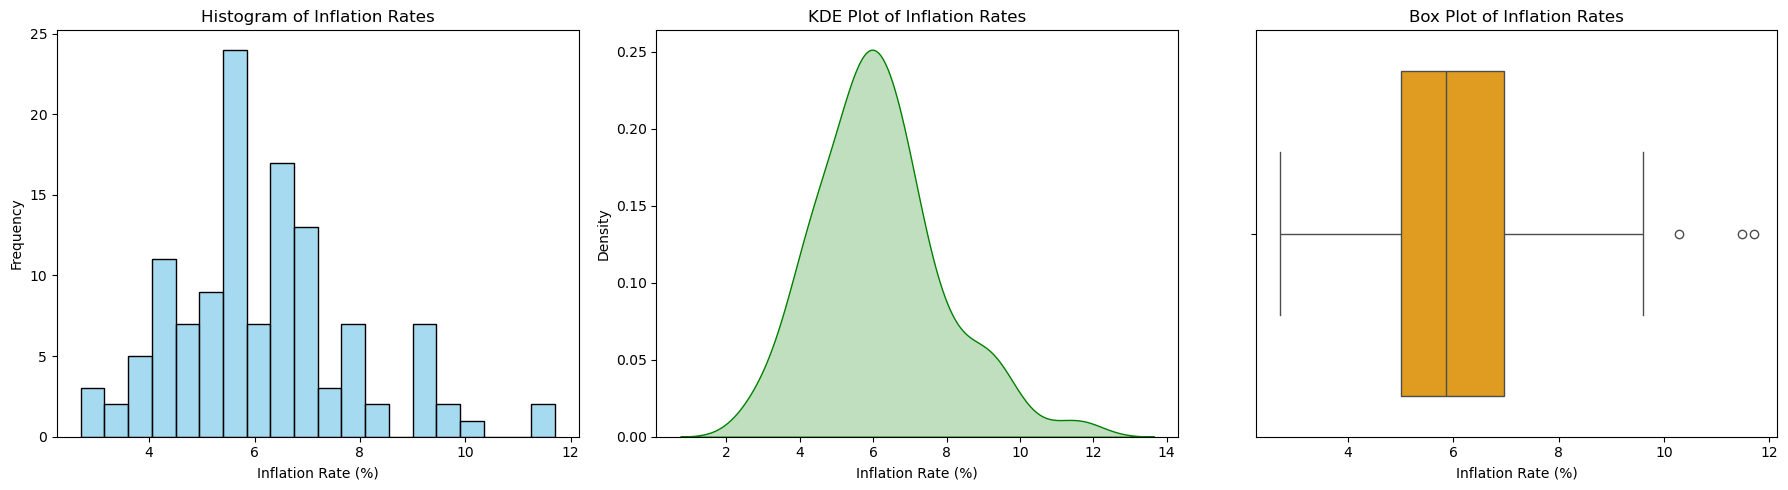

In [27]:

inflation_values = cpi['inflation rate (%)']

plt.figure(figsize=(18, 5))

# Histogram
plt.subplot(1, 3, 1)
sns.histplot(inflation_values, bins=20, kde=False, color='skyblue')
plt.title('Histogram of Inflation Rates')
plt.xlabel('Inflation Rate (%)')
plt.ylabel('Frequency')

# KDE Plot
plt.subplot(1, 3, 2)
sns.kdeplot(inflation_values, shade=True, color='green')
plt.title('KDE Plot of Inflation Rates')
plt.xlabel('Inflation Rate (%)')

# Box Plot
plt.subplot(1, 3, 3)
sns.boxplot(x=inflation_values, color='orange')
plt.title('Box Plot of Inflation Rates')
plt.xlabel('Inflation Rate (%)')

plt.tight_layout()
plt.show()


For the boxplot, as we can see the inflation rates has numerous outliers. As for our data, all these outliers contain valuable information, which will be very important to our models. As such, we will not be eliminating data.

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1296\1960169271.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cpi_values, shade=True, color='green')


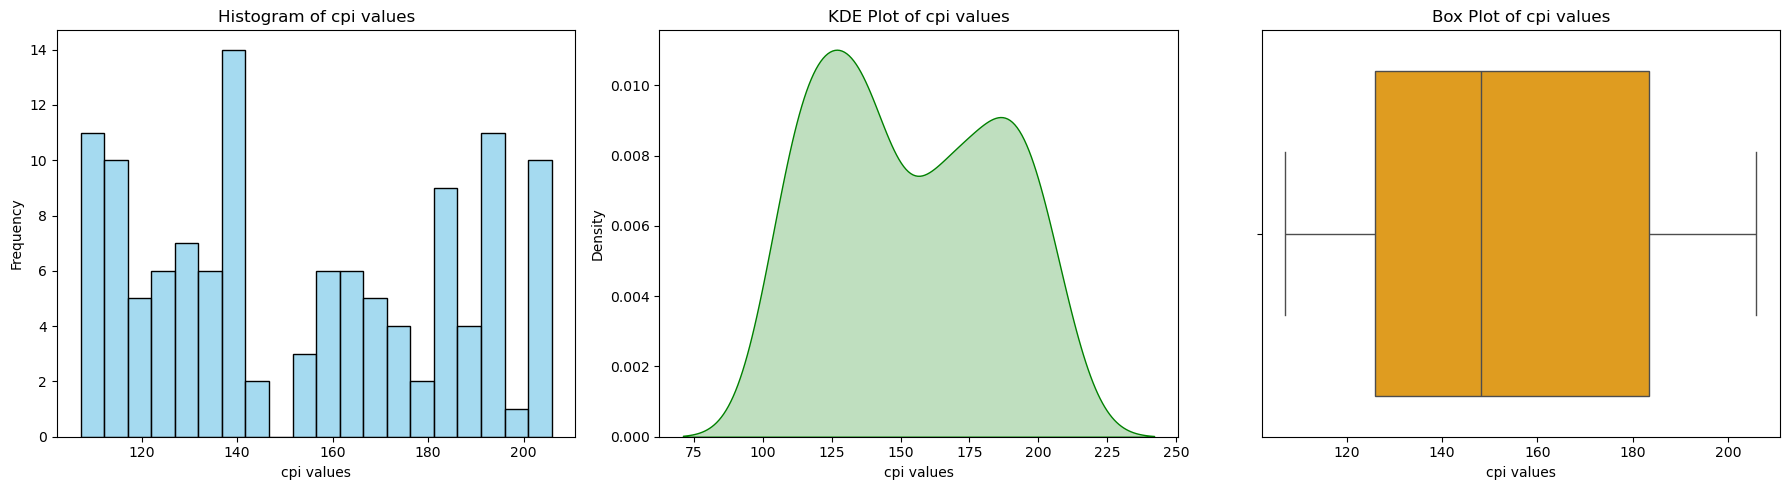

In [29]:
#2.cpi
cpi_values = cpi['cpi']

plt.figure(figsize=(18, 5))
# Histogram 
plt.subplot(1, 3, 1)
sns.histplot(cpi_values, bins=20, kde=False, color='skyblue')
plt.title('Histogram of cpi values')
plt.xlabel('cpi values')
plt.ylabel('Frequency')

# KDE Plot
plt.subplot(1, 3, 2)
sns.kdeplot(cpi_values, shade=True, color='green')
plt.title('KDE Plot of cpi values')
plt.xlabel('cpi values')

# Box Plot
plt.subplot(1, 3, 3)
sns.boxplot(x=cpi_values, color='orange')
plt.title('Box Plot of cpi values')
plt.xlabel('cpi values')

plt.tight_layout()
plt.show()

### 2.Bivariate Analysis

Used when you want to explore the relationship between two variables.

**a.Inflation rate (%) vs interest rate (%), exchange rate\n (kes/usd), food cpi**

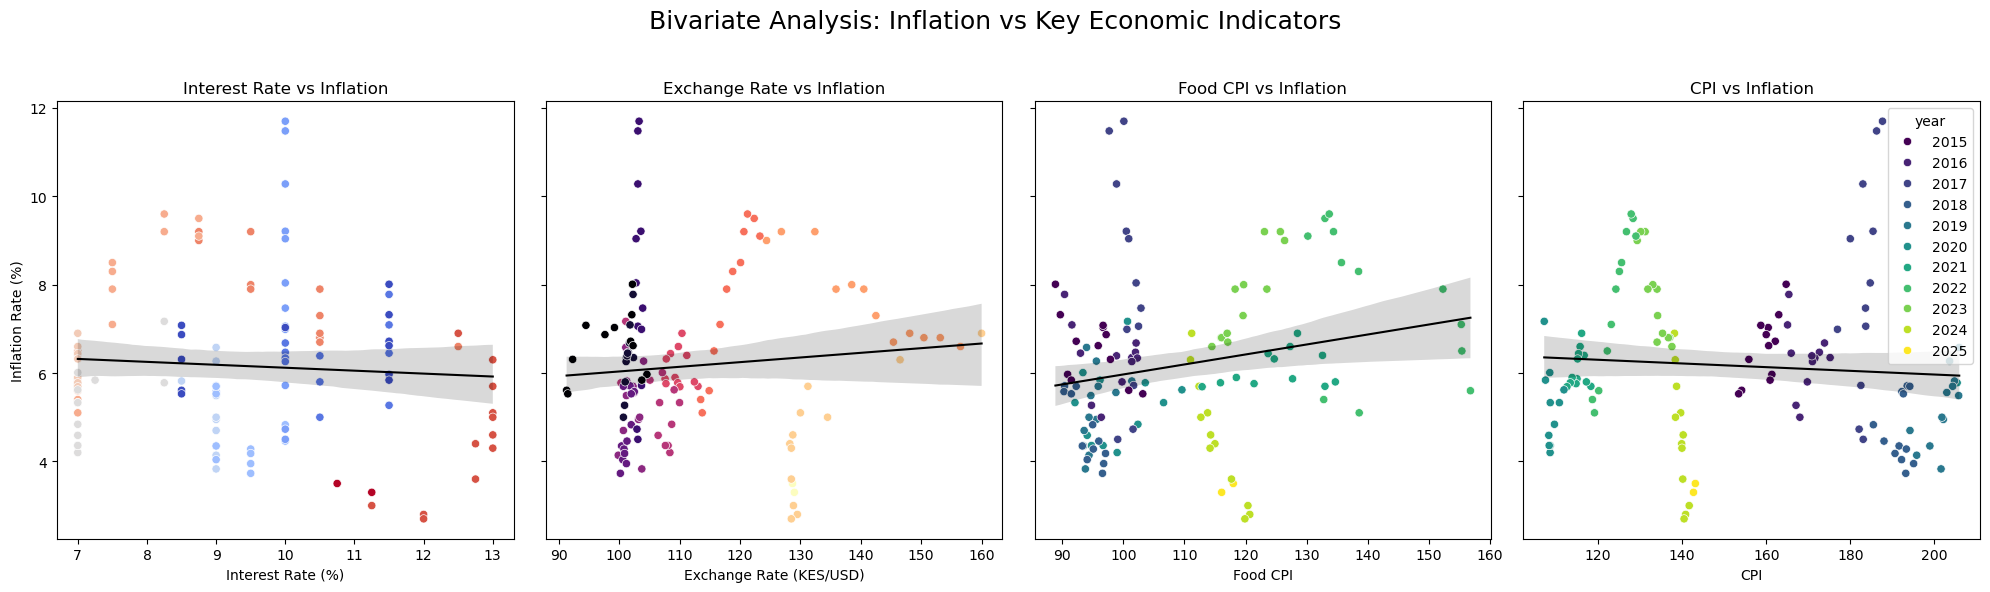

In [31]:

# Set the plot size and layout
fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=True)
fig.suptitle('Bivariate Analysis: Inflation vs Key Economic Indicators', fontsize=18)

# 1. Inflation vs Interest Rate
sns.scatterplot(ax=axes[0], data=cpi, x='interest rate (%)', y='inflation rate (%)', hue='year', palette='coolwarm', legend=False)
sns.regplot(ax=axes[0], data=cpi, x='interest rate (%)', y='inflation rate (%)', scatter=False, color='black', line_kws={'linewidth': 1.5})
axes[0].set_title('Interest Rate vs Inflation')
axes[0].set_xlabel('Interest Rate (%)')
axes[0].set_ylabel('Inflation Rate (%)')

# 2. Inflation vs Exchange Rate
sns.scatterplot(ax=axes[1], data=cpi, x='exchange rate\n (kes/usd)', y='inflation rate (%)', hue='year', palette='magma', legend=False)
sns.regplot(ax=axes[1], data=cpi, x='exchange rate\n (kes/usd)', y='inflation rate (%)', scatter=False, color='black', line_kws={'linewidth': 1.5})
axes[1].set_title('Exchange Rate vs Inflation')
axes[1].set_xlabel('Exchange Rate (KES/USD)')
axes[1].set_ylabel('')

# 3. Inflation vs Food CPI
sns.scatterplot(ax=axes[2], data=cpi, x='food cpi', y='inflation rate (%)', hue='year', palette='viridis', legend=False)
sns.regplot(ax=axes[2], data=cpi, x='food cpi', y='inflation rate (%)', scatter=False, color='black', line_kws={'linewidth': 1.5})
axes[2].set_title('Food CPI vs Inflation')
axes[2].set_xlabel('Food CPI')
axes[2].set_ylabel('')

# 4. Inflation vs cpi
sns.scatterplot(ax=axes[3], data=cpi, x='cpi', y='inflation rate (%)', hue='year', palette='viridis', legend='full')
sns.regplot(ax=axes[3], data=cpi, x='cpi', y='inflation rate (%)', scatter=False, color='black', line_kws={'linewidth': 1.5})
axes[3].set_title('CPI vs Inflation')
axes[3].set_xlabel('CPI')
axes[3].set_ylabel('')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Each dot is a monthly observation, colored by year to show temporal changes.

Interest Rate vs Inflation : There is a slight negative relationship (trend line slopes down). As interest rates increase, inflation tends to slightly decrease. Weak or flat correlation, but a mild downward trend is visible.

Exchange Rate vs Inflation : A slight positive relationship. As the Kenyan Shilling depreciates (higher exchange rate = weaker KES), inflation increases. A mild upward trend. Inflation seems to rise with increasing exchange rate.

Food CPI vs inflation rate : A clearer positive relationship. When food prices rise, overall inflation rises too. Among the three, this shows the strongest correlation with inflation, suggesting food prices are a key inflation driver.

cpi vs Inflation : There is a slight negative relationship. As Cpi incraeses, inflation tends to slightly decrease. Weak or flat correlation, but a downward trend is visible.

In [41]:

# Keep only year, month, and inflation rate
inflation2 = cpi[['year', 'month', 'inflation rate (%)']]

# Convert to datetime and extract quarter
# Combine year and month into a date
inflation2['month'] = inflation2['month'].astype(str)
inflation2['date'] = pd.to_datetime(inflation2['month'] + ' ' + inflation2['year'].astype(str))

# Extract quarter and year again (for easy merge)
inflation2['quarter'] = inflation2['date'].dt.to_period('Q').astype(str)
inflation2['year'] = inflation2['date'].dt.year

# Aggregate to quarterly inflation
inflation_quarterly = inflation2.groupby(['year', 'quarter'], as_index=False).agg({
    'inflation rate (%)': 'mean'
})

inflation_quarterly.head()


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1296\3233490602.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inflation2['month'] = inflation2['month'].astype(str)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_1296\3233490602.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  inflation2['date'] = pd.to_datetime(inflation2['month'] + ' ' + inflation2['year'].astype(str))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_1296\3233490602.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,year,quarter,inflation rate (%)
0,2015,2015Q1,5.816667
1,2015,2015Q2,6.993333
2,2015,2015Q3,6.143333
3,2015,2015Q4,7.350000
4,2016,2016Q1,7.106667


In [51]:
df = pd.merge(gdpgrowth, inflation_quarterly, on=['year'], how='inner')
df

,year,quarter_x,gdp growth rate (%),gdp value (kes billion),quarter_length,quarter_y,inflation rate (%)
0,2025,Q1,NaN,NaN,1,2025Q1,3.400000
1,2025,Q2,NaN,NaN,1,2025Q1,3.400000
2,2025,Q3,NaN,NaN,1,2025Q1,3.400000
3,2025,Q4,NaN,NaN,1,2025Q1,3.400000
4,2024,Q1,5.3,14000.0,1,2024Q1,6.300000
...,...,...,...,...,...,...,...
159,2015,Q3,5.7,8900.0,1,2015Q4,7.350000
160,2015,Q4,5.3,8600.0,1,2015Q1,5.816667
161,2015,Q4,5.3,8600.0,1,2015Q2,6.993333
162,2015,Q4,5.3,8600.0,1,2015Q3,6.143333


In [52]:
df = df.drop(['quarter_y', 'quarter_length'], axis=1)
df

,year,quarter_x,gdp growth rate (%),gdp value (kes billion),inflation rate (%)
0,2025,Q1,NaN,NaN,3.400000
1,2025,Q2,NaN,NaN,3.400000
2,2025,Q3,NaN,NaN,3.400000
3,2025,Q4,NaN,NaN,3.400000
4,2024,Q1,5.3,14000.0,6.300000
...,...,...,...,...,...
159,2015,Q3,5.7,8900.0,7.350000
160,2015,Q4,5.3,8600.0,5.816667
161,2015,Q4,5.3,8600.0,6.993333
162,2015,Q4,5.3,8600.0,6.143333


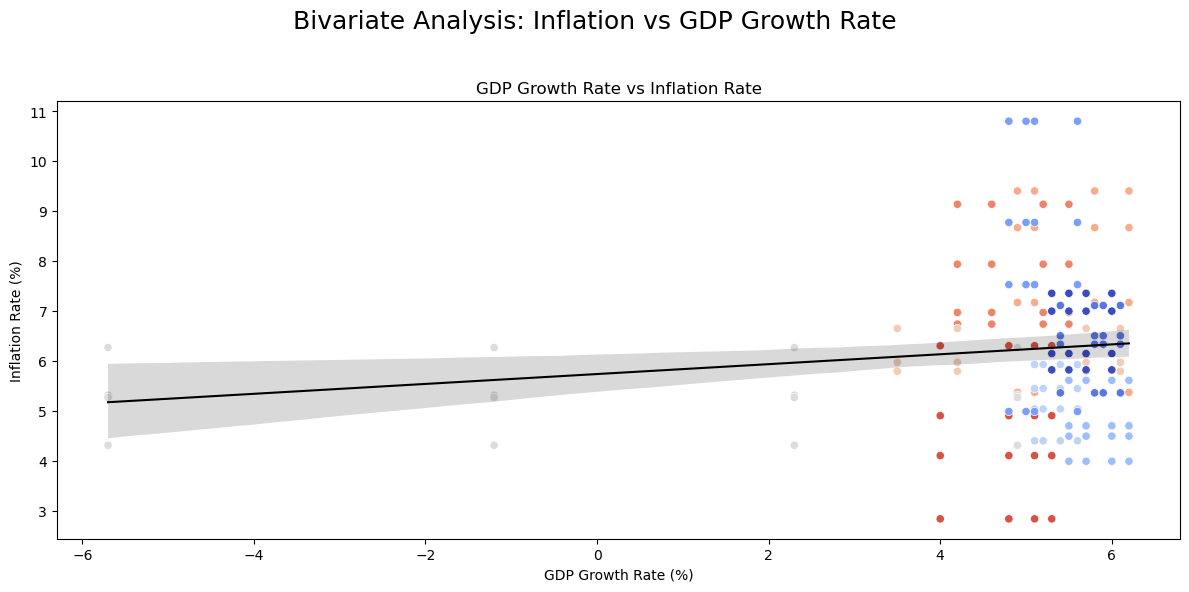

In [57]:
# Set the plot size
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Bivariate Analysis: Inflation vs GDP Growth Rate', fontsize=18)

# Scatter plot with regression line
sns.scatterplot(data=df, x='gdp growth rate (%)', y='inflation rate (%)', hue='year', palette='coolwarm', ax=ax, legend=False)
sns.regplot(data=df, x='gdp growth rate (%)', y='inflation rate (%)', scatter=False, color='black', line_kws={'linewidth': 1.5}, ax=ax)

# Labeling
ax.set_title('GDP Growth Rate vs Inflation Rate')
ax.set_xlabel('GDP Growth Rate (%)')
ax.set_ylabel('Inflation Rate (%)')

# Layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 3. Multivariate Analysis

Use this when you want to analyze more than two variables simultaneously (e.g., how multiple economic factors like CPI, food CPI, and exchange rates affect inflation).

Used a correlation matrix to identify the correlation between different variables in the dataset.

**a.cpi**

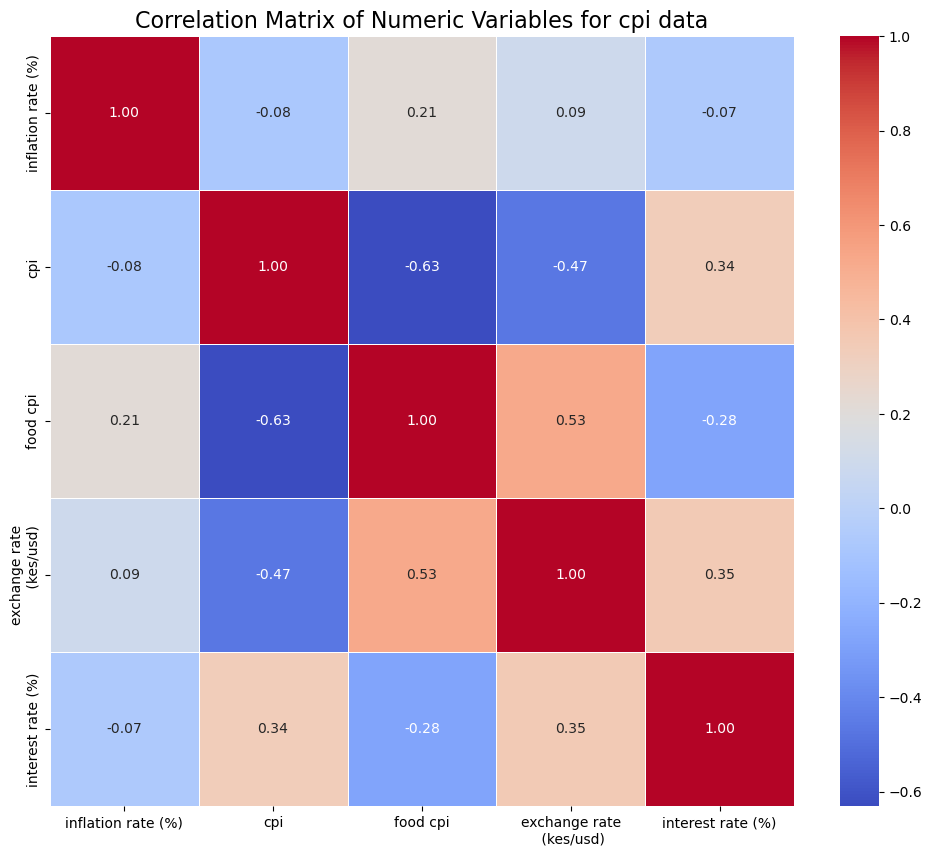

In [ ]:
# Select only numeric columns
num_vars = cpi.select_dtypes(include=['number','float64', 'int64']).columns
num_vars = num_vars.drop(['year', 'month_length'], errors='ignore')

# Extract numeric DataFrame using the selected columns
numeric_df = cpi[num_vars]

# Calculate the correlation matrix
corr_matrix = numeric_df .corr()

# Generate the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Numeric Variables for cpi data", fontsize=16) 
# Save the plot
#plt.savefig("fig11_name.png", dpi=300, bbox_inches='tight')
plt.show()